📝 **Customer Segmentation Project Report**
1. Problem Statement


The retail company needs to better understand its customers in order to:

Improve targeted marketing efforts.

Increase customer retention by identifying at-risk customers.

Enhance personalization strategies to boost engagement and revenue.

Currently, marketing campaigns are broad and not personalized, leading to wasted budget and lower ROI. To solve this, we aim to build a data-driven customer segmentation model.


2. Data Overview

We used an online retail transactions dataset containing ~541,900 records of customer purchases. The key fields include:

InvoiceNo – unique identifier for each transaction.

StockCode & Description – product purchased.

Quantity – number of items purchased.

InvoiceDate – date of purchase.

UnitPrice – price per unit.

CustomerID – unique customer identifier.

Country – customer location.

After cleaning (removing cancellations, negative values, and missing IDs), the dataset was ready for analysis.


3. Methodology
Step 1: RFM Framework

We adopted the RFM (Recency, Frequency, Monetary) framework, which is widely used in customer analytics:

Recency (R): Days since the customer’s last purchase.

Frequency (F): Total number of purchases.

Monetary (M): Total money spent.

This framework captures customer engagement and value.

Step 2: Data Processing

Defined “today” as the day after the latest transaction in the dataset (2011-12-10).

Calculated RFM values for each customer.

Standardized the RFM data (to ensure fair comparison across different scales).

Step 3: Clustering

Applied KMeans clustering to group customers into segments.

Determined the optimal number of clusters (K=4) using the Elbow method and Silhouette score.

Step 4: Visualization & Profiling

Plotted histograms, scatterplots, and correlation heatmaps to explore RFM behavior.

Created cluster summaries and visual comparisons.



4. Results: Customer Segments

Cluster 0 – Regular Active Customers

Recency: ~44 days

Frequency: ~4 purchases

Monetary: ~$1,359

Moderate spenders who are still engaged. Opportunity to build loyalty with targeted offers.

Cluster 1 – At-Risk / Churned Customers

Recency: ~248 days

Frequency: ~1.5 purchases

Monetary: ~$480

Customers who haven’t purchased for a long time. Require win-back campaigns (email reminders, discounts).

Cluster 2 – VIP Customers

Recency: ~7 days

Frequency: ~82 purchases

Monetary: ~$127,000

Most valuable group. Loyal, recent, and very high spenders. Retain with exclusive offers, early access to products, and premium services.

Cluster 3 – Loyal Regulars

Recency: ~15 days

Frequency: ~22 purchases

Monetary: ~$12,700

Highly engaged and strong contributors to revenue. Focus on upselling and turning them into VIPs.



5. Business Recommendations

VIP Customers (Cluster 2)

Provide exclusive rewards programs.

Personalized thank-you campaigns.

Early access to sales.

Loyal Regulars (Cluster 3)

Promote upsell/cross-sell opportunities.

Encourage referrals.

Strengthen loyalty programs.

Regular Active Customers (Cluster 0)

Send personalized product recommendations.

Offer small incentives (discounts, loyalty points) to increase frequency.

At-Risk Customers (Cluster 1)

Launch win-back campaigns (emails with discounts).

Highlight new arrivals and seasonal promotions.

Monitor response to see if they re-engage.



6. Conclusion

Through RFM-based customer segmentation, we transformed a large transactional dataset into 4 actionable customer groups. This provides the business with a roadmap to:

Retain high-value customers,

Re-engage at-risk customers, and

Optimize marketing spend by tailoring campaigns to each group.

This data-driven strategy ensures more effective personalization, higher customer lifetime value, and improved marketing ROI.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Reading the CSV file
df = pd.read_csv("/content/drive/My Drive/customerSegmentation/data.csv", encoding='latin1')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.shape

(541909, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df = df.dropna(subset=['Description', 'CustomerID'])

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [11]:
df = df[(df['Quantity']>0) & (df['UnitPrice']> 0)]

In [12]:
df['totalPrice'] = df['Quantity'] * df['UnitPrice']

In [13]:
# Reference date (1 day after the latest purchase in dataset)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Reference Date:", reference_date)


Reference Date: 2011-12-10 12:50:00


In [14]:
# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency (number of orders)
    'totalPrice': 'sum'                                       # Monetary (total spent)
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


In [15]:
print("Number of customers:", rfm.shape[0])
rfm.describe()


Number of customers: 4338


,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


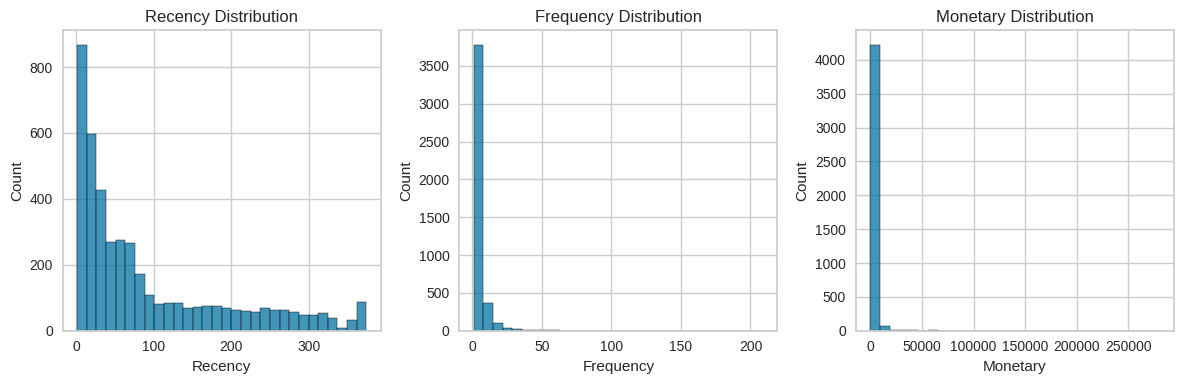

In [16]:
# Plot distribution of Recency, Frequency, and Monetary
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30, kde=False)
plt.title('Recency Distribution')

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30, kde=False)
plt.title('Frequency Distribution')

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30, kde=False)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

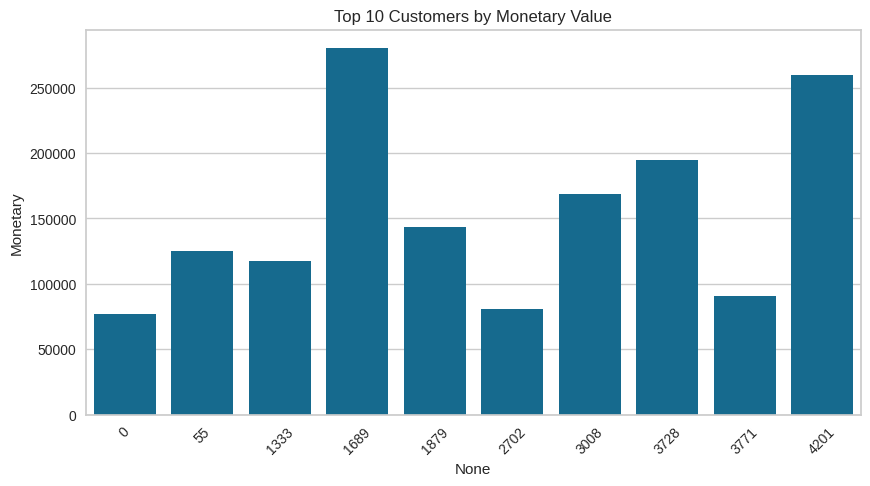

In [17]:
# Top customers by Monetary value
top_customers = rfm.sort_values('Monetary', ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_customers.index, y=top_customers['Monetary'])
plt.xticks(rotation=45)
plt.title('Top 10 Customers by Monetary Value')
plt.show()


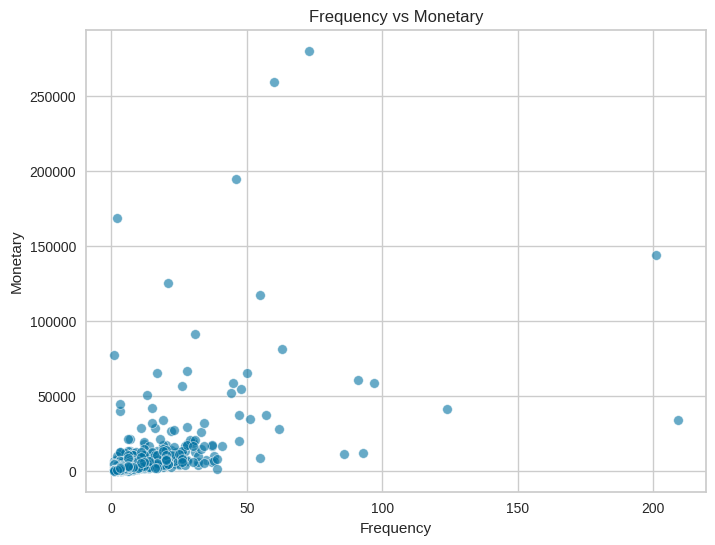

In [18]:
# Scatter plot: Frequency vs Monetary
plt.figure(figsize=(8,6))
sns.scatterplot(x='Frequency', y='Monetary', data=rfm, alpha=0.6)
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

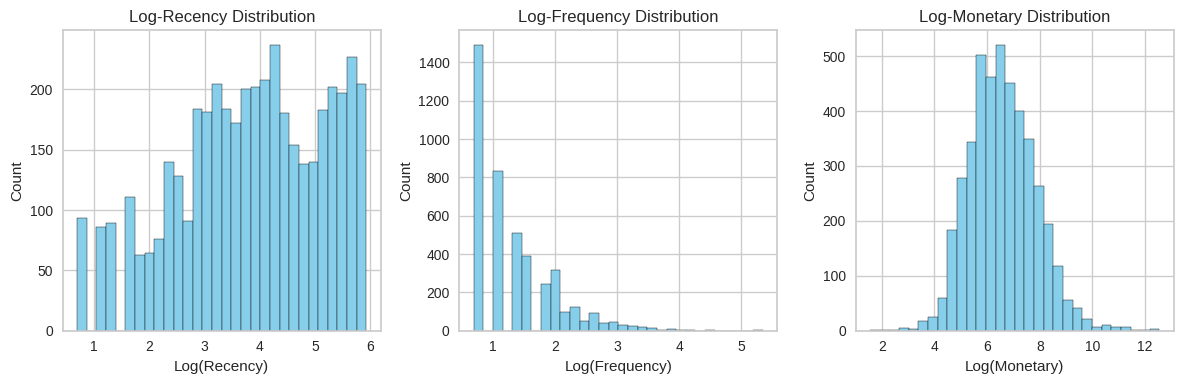

In [19]:
# Apply log transformation (add 1 to avoid log(0))
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x))

# Plot histograms again
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(rfm_log['Recency'], bins=30, color='skyblue', edgecolor='black')
plt.title('Log-Recency Distribution')
plt.xlabel('Log(Recency)')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(rfm_log['Frequency'], bins=30, color='skyblue', edgecolor='black')
plt.title('Log-Frequency Distribution')
plt.xlabel('Log(Frequency)')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(rfm_log['Monetary'], bins=30, color='skyblue', edgecolor='black')
plt.title('Log-Monetary Distribution')
plt.xlabel('Log(Monetary)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


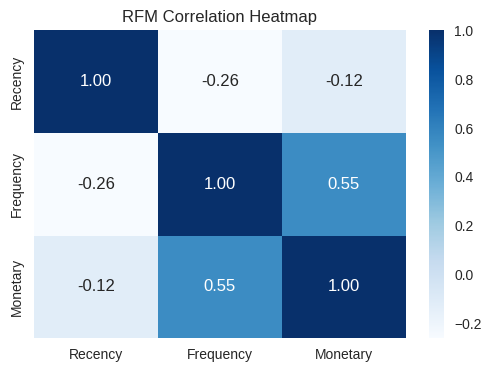

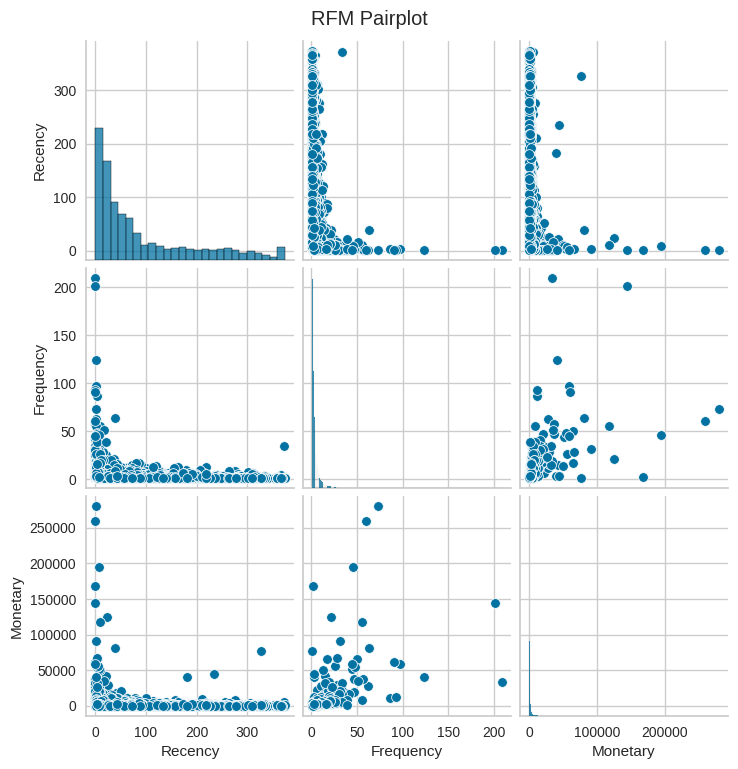

In [20]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('RFM Correlation Heatmap')
plt.show()

# Pairplot to visualize interactions
sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary']])
plt.suptitle('RFM Pairplot', y=1.02)
plt.show()

In [21]:
# Select RFM features
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to DataFrame for convenience
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

rfm_scaled.head()

,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.358668
1,-0.905340,0.354417,0.250966
2,-0.175360,-0.035340,-0.028596
3,-0.735345,-0.425097,-0.033012
4,2.174578,-0.425097,-0.191347


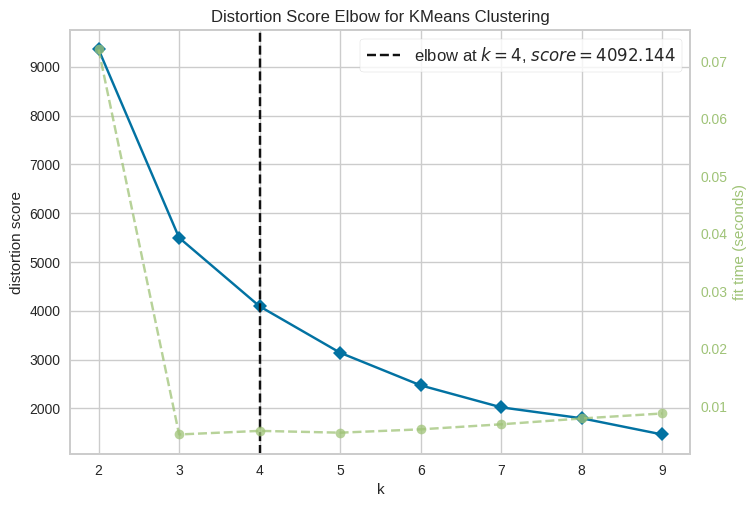

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:


# Instantiate the clustering model with a range of k values
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))

# Fit the data to the visualizer
visualizer.fit(rfm_scaled)

# Finalize and render the figure
visualizer.show()

In [23]:
# Apply KMeans clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display the first few rows with the new cluster labels
display(rfm.head())

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,3
1,12347,2,7,4310.00,0
2,12348,75,4,1797.24,0
3,12349,19,1,1757.55,0
4,12350,310,1,334.40,1


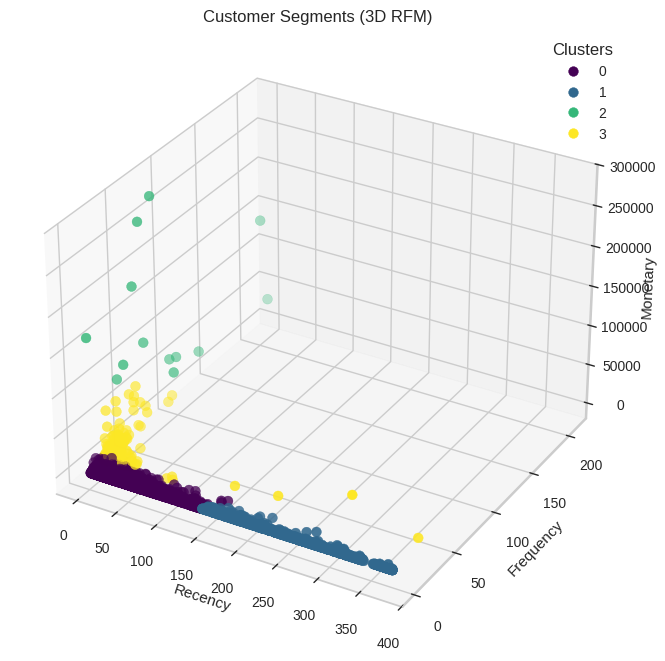

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot points, colored by cluster
scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', s=50)

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Customer Segments (3D RFM)')

# Add a color bar
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [25]:
# Calculate the mean RFM values for each cluster
cluster_means = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Display the cluster means
display(cluster_means)

,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [26]:
# Explore country distribution within clusters
cluster_country = rfm.merge(df[['CustomerID', 'Country']], on='CustomerID', how='left')
cluster_country_counts = cluster_country.groupby(['Cluster', 'Country']).size().reset_index(name='Count')

# Display the country counts per cluster
display(cluster_country_counts.sort_values(['Cluster', 'Count'], ascending=[True, False]))

,Cluster,Country,Count
28,0,United Kingdom,231251
11,0,Germany,6257
10,0,France,5524
23,0,Spain,1917
2,0,Belgium,1800
...,...,...,...
68,3,Portugal,371
69,3,Singapore,222
71,3,Sweden,198
64,3,Australia,181


In [27]:
# Filter cluster_country_counts for Cluster 3
cluster3_country_counts = cluster_country_counts[cluster_country_counts['Cluster'] == 3]

# Display the country counts for Cluster 3, sorted by count
display(cluster3_country_counts.sort_values('Count', ascending=False))

,Cluster,Country,Count
72,3,United Kingdom,76825
66,3,France,2392
67,3,Germany,2101
70,3,Spain,478
68,3,Portugal,371
69,3,Singapore,222
71,3,Sweden,198
64,3,Australia,181
65,3,Belgium,54


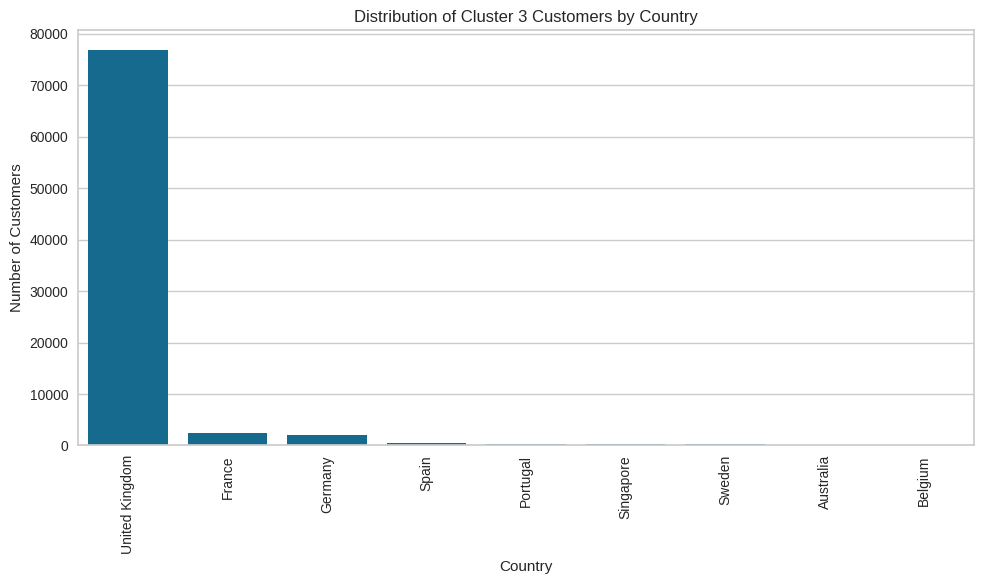

In [28]:
# Visualize the country distribution for Cluster 3
plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Count', data=cluster3_country_counts.sort_values('Count', ascending=False))
plt.xticks(rotation=90)
plt.title('Distribution of Cluster 3 Customers by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

In [29]:
# Filter cluster_country_counts for Cluster 2
cluster2_country_counts = cluster_country_counts[cluster_country_counts['Cluster'] == 2]

# Display the country counts for Cluster 2, sorted by count
display(cluster2_country_counts.sort_values('Count', ascending=False))

,Cluster,Country,Count
63,2,United Kingdom,18615
61,2,EIRE,7075
62,2,Netherlands,2076
60,2,Australia,714


In [30]:
# Filter cluster_country_counts for Cluster 1
cluster1_country_counts = cluster_country_counts[cluster_country_counts['Cluster'] == 1]

# Display the country counts for Cluster 1, sorted by count
display(cluster1_country_counts.sort_values('Count', ascending=False))

,Cluster,Country,Count
58,1,United Kingdom,27630
41,1,Germany,682
40,1,France,425
33,1,Belgium,177
55,1,Switzerland,163
38,1,EIRE,161
35,1,Canada,146
51,1,Portugal,132
44,1,Italy,117
42,1,Greece,109


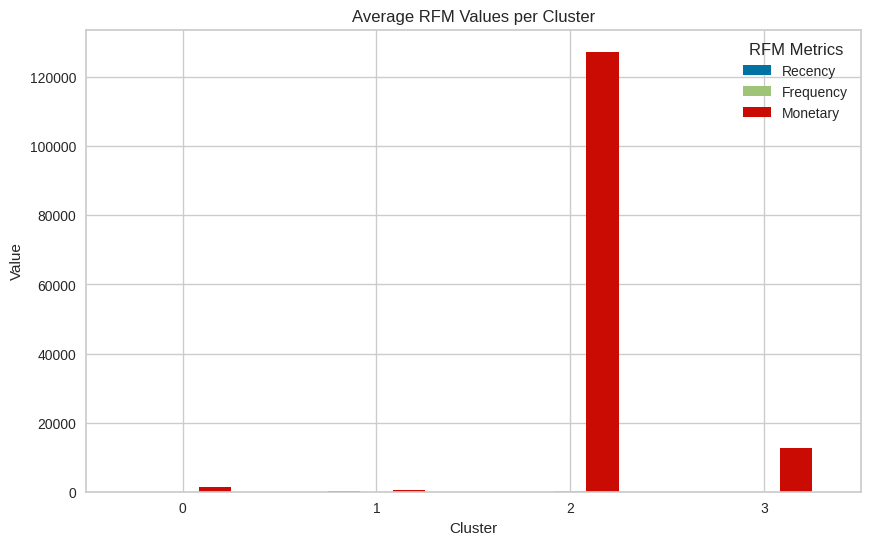

In [31]:
# Calculate mean values per cluster
cluster_summary = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

# Plot bar chart
cluster_summary.plot(kind='bar', figsize=(10,6))
plt.title('Average RFM Values per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.legend(title='RFM Metrics')
plt.show()

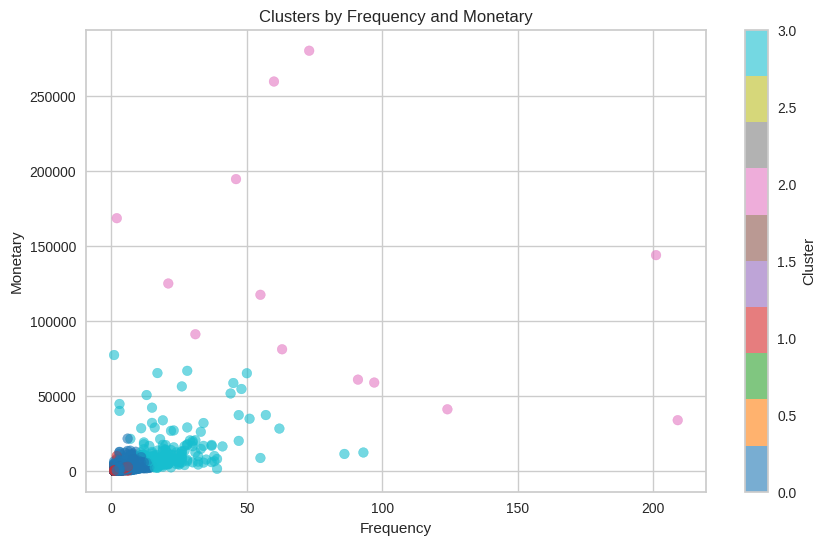

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='tab10', alpha=0.6)
plt.title('Clusters by Frequency and Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.colorbar(label='Cluster')
plt.show()


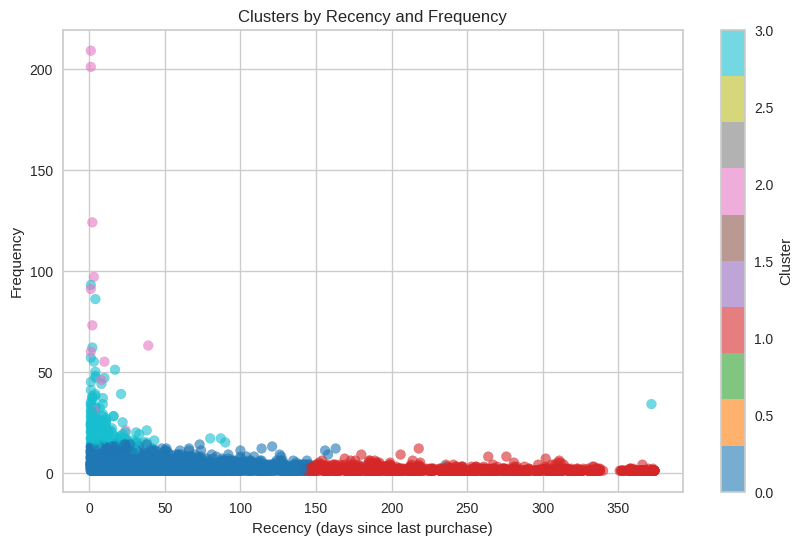

In [33]:
plt.figure(figsize=(10,6))
plt.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='tab10', alpha=0.6)
plt.title('Clusters by Recency and Frequency')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency')
plt.colorbar(label='Cluster')
plt.show()
